# Fourier Amplitude Difference correction in Stingray

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from stingray import EventList, AveragedCrossspectrum, AveragedPowerspectrum
from stingray.deadtime.fad import calculate_FAD_correction, FAD
from stingray.filters import filter_for_deadtime

import matplotlib.pyplot as plt


Dead time affects most counting experiments. While the instrument is busy processing one event, it is "dead" to other photons/particles hitting the detector. This is usually not an issue if the count rate is low enough, or the processing time (_dead_ time) is small enough. However, at high count rate dead time affects greatly the statistical properties of the data, to a point where a standard periodicity search based on the periodogram/power density spectrum (PDS) cannot be carried out.

The Fourier Amplitude Difference (FAD) correction is described in [Bachetti & Huppenkothen, 2018, ApJ, 853L, 21](https://ui.adsabs.harvard.edu/abs/2018ApJ...853L..21B), and is able to correct precisely deadtime affected PDSs if we have at least two identical and independent detectors. This is common in new generation X-ray timing instruments, often based on multiple-detector configurations (e.g. NuSTAR, NICER, AstroSAT, etc.).

In the code below, we calculate the PDS of light curves without dead time, after applying a dead time filter, and after applying the FAD to the dead-time affected dataset. 

In [2]:
def generate_events(length, ncounts):
    ev = np.random.uniform(0, length, ncounts)
    ev.sort()
    return ev


In [3]:
ctrate = 500
dt = 0.001
deadtime = 2.5e-3
tstart = 0
length = 25600
segment_size = 256.
ncounts = int(ctrate * length)
ev1 = EventList(generate_events(length, ncounts), mjdref=58000, gti=[[tstart, length]])
ev2 = EventList(generate_events(length, ncounts), mjdref=58000, gti=[[tstart, length]])

pds1 = AveragedPowerspectrum.from_events(ev1, dt=dt, segment_size=segment_size, norm='leahy')
pds2 = AveragedPowerspectrum.from_events(ev2, dt=dt, segment_size=segment_size, norm='leahy')
ptot = AveragedPowerspectrum.from_events(ev1.join(ev2), dt=dt, segment_size=segment_size, norm='leahy')
cs = AveragedCrossspectrum.from_events(ev1, ev2, dt=dt, segment_size=segment_size, norm='leahy')

100it [00:01, 79.34it/s]
100it [00:01, 96.21it/s]
100it [00:01, 75.32it/s]
100it [00:01, 51.02it/s]


Now let us apply a deadtime filter to the events generated above, and calculate the corresponding periodograms

In [4]:
ev1_dt = ev1.apply_deadtime(deadtime)
ev2_dt = ev2.apply_deadtime(deadtime)

pds1_dt = AveragedPowerspectrum.from_events(ev1_dt, dt=dt, segment_size=segment_size, norm='leahy')
pds2_dt = AveragedPowerspectrum.from_events(ev2_dt, dt=dt, segment_size=segment_size, norm='leahy')
ptot_dt = AveragedPowerspectrum.from_events(ev1_dt.join(ev2_dt), dt=dt, segment_size=segment_size, norm='leahy')
cs_dt = AveragedCrossspectrum.from_events(ev1_dt, ev2_dt, dt=dt, segment_size=segment_size, norm='leahy')

100it [00:00, 111.98it/s]
100it [00:00, 125.16it/s]
100it [00:00, 116.25it/s]
100it [00:01, 58.53it/s]


The FAD method relies on averaging out many values of the difference between the Fourier transforms in the two channels in *contiguous frequencies*, and **it works best when the frequency resolution is very high** compared with the distortion of the power spectrum due to deadtime. 

For example, in NuSTAR the effect of deadtime appears above $\sim10$ Hz. We want to calculate the correction on a Hz-by-Hz basis, so that the correction is adequate. The frequency resolution from the FFT is `1/segment_size`. 

Therefore, **the `segment_size` should ideally be some hundred seconds** to have some hundred bins in a Hz. The smoothing length should be of the order of the number of bins in $\sim1$ Hz (in this example 2Hz).

In [5]:
results = \
    FAD(ev1_dt, ev2_dt, segment_size, dt, norm="leahy", plot=False,
                      smoothing_alg='gauss',
                      smoothing_length=segment_size*2,
                      strict=True, verbose=False,
                      tolerance=0.05)

freq_f = results['freq']
pds1_f = results['pds1']
pds2_f = results['pds2']
cs_f = results['cs']
ptot_f = results['ptot']


0it [00:00, ?it/s]

100it [00:35,  2.79it/s]


/home/saurav/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/saurav/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


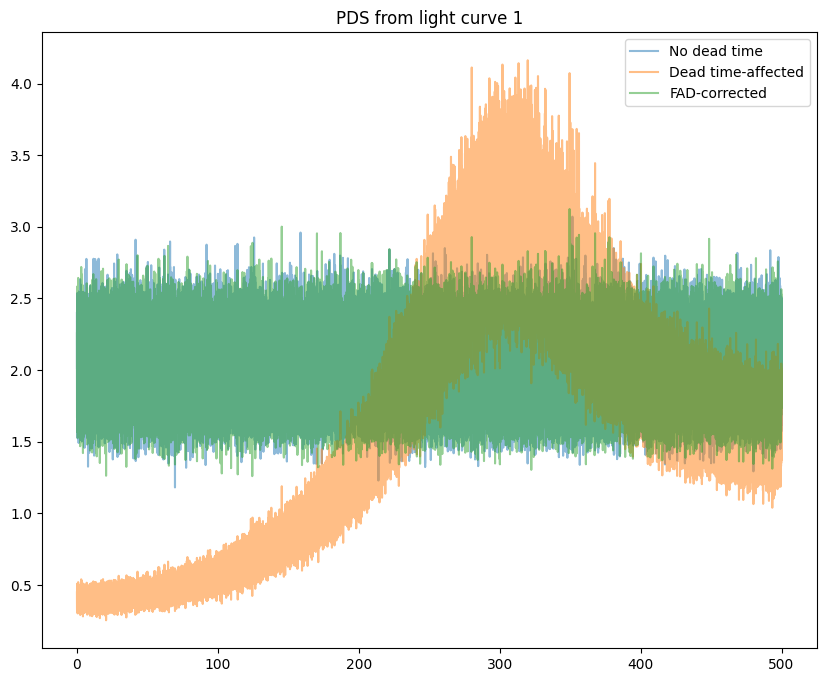

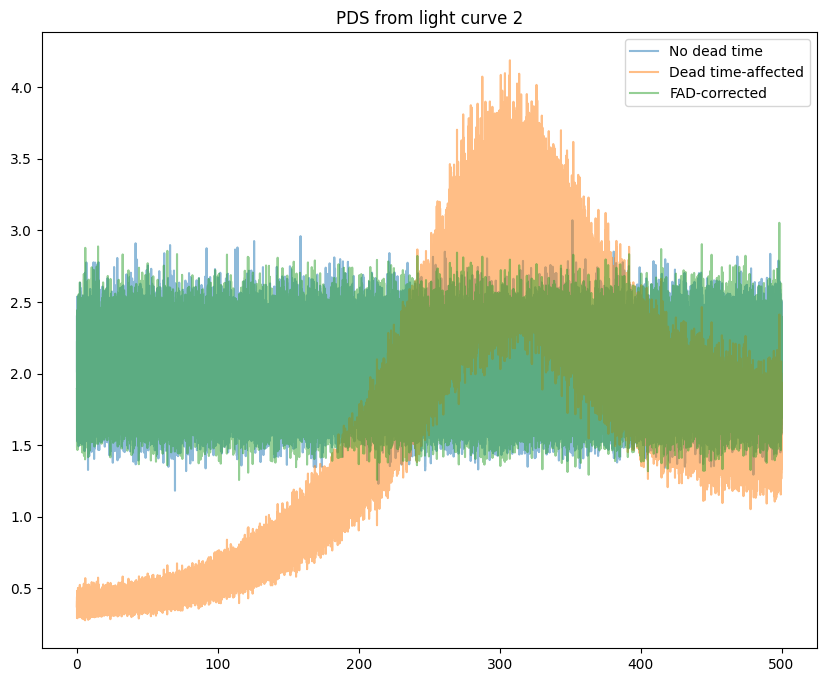

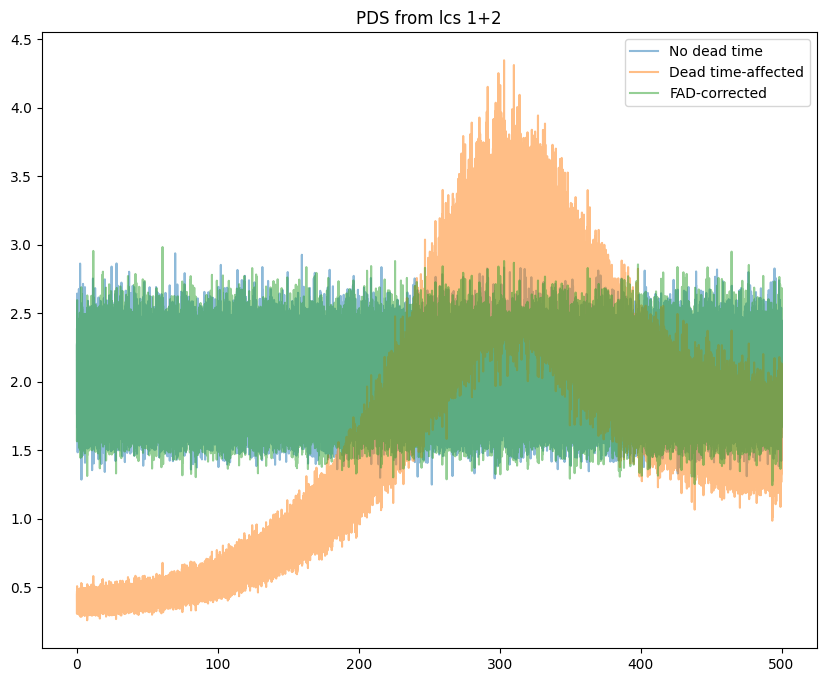

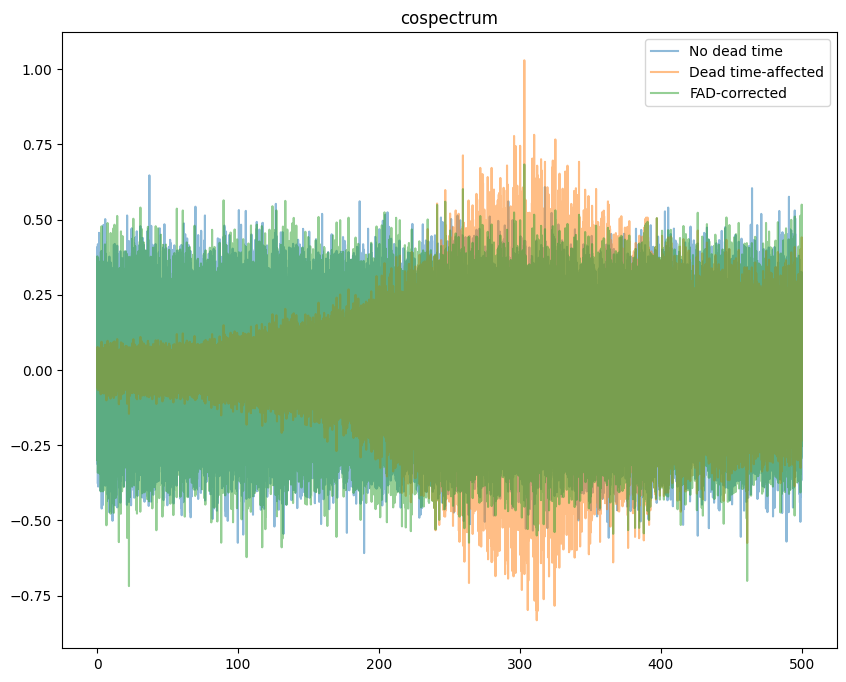

In [6]:
for spec, spec_dt, spec_f, label in zip(
        [pds1, pds1, ptot, cs],
        [pds1_dt, pds2_dt, ptot_dt, cs_dt],
        [pds1_f, pds2_f, ptot_f, cs_f],
        ['PDS from light curve 1', 'PDS from light curve 2', 'PDS from lcs 1+2', 'cospectrum']
        ):
    plt.figure(figsize=(10, 8))
    plt.title(label)
    plt.plot(spec.freq, spec.power, label='No dead time', alpha=0.5)
    plt.plot(spec_dt.freq, spec_dt.power, label='Dead time-affected', alpha=0.5)
    plt.plot(freq_f, spec_f, label='FAD-corrected', alpha=0.5)
    plt.legend()

As can be seen above, all power density and co- spectra have been corrected accurately in their basic property (the white noise level). See Bachetti & Huppenkothen 2019 for more information.

Note that this can also be done starting from light curves:

100it [00:34,  2.87it/s]


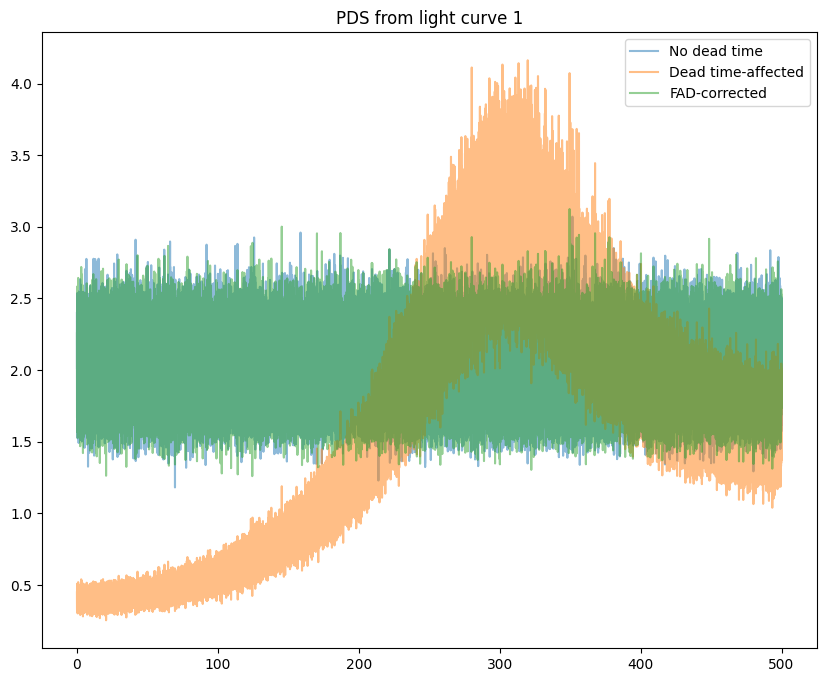

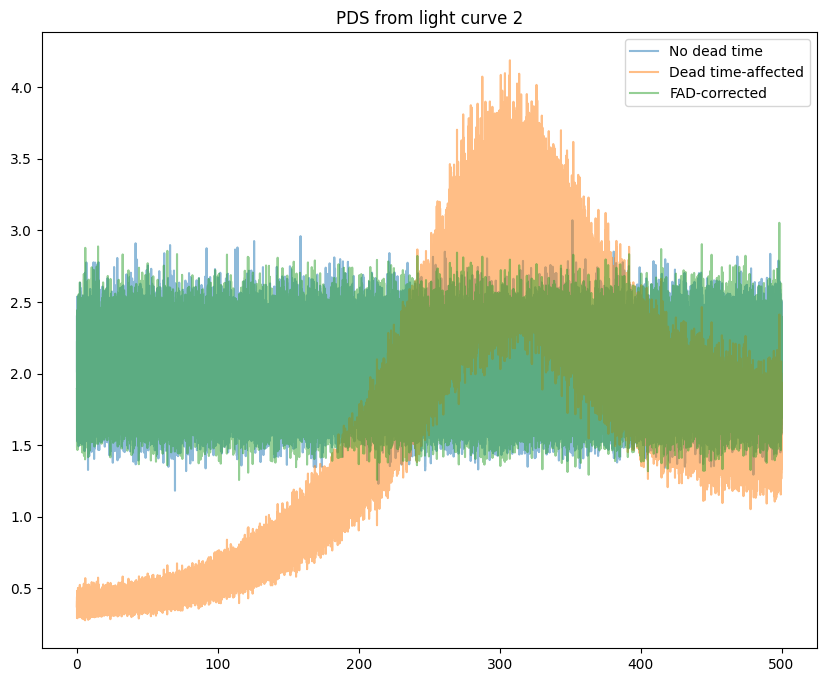

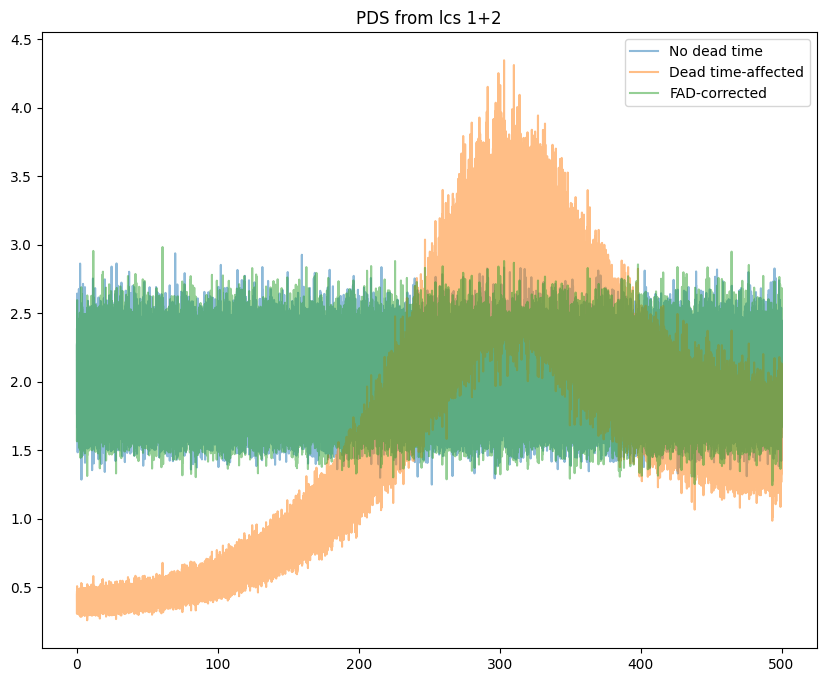

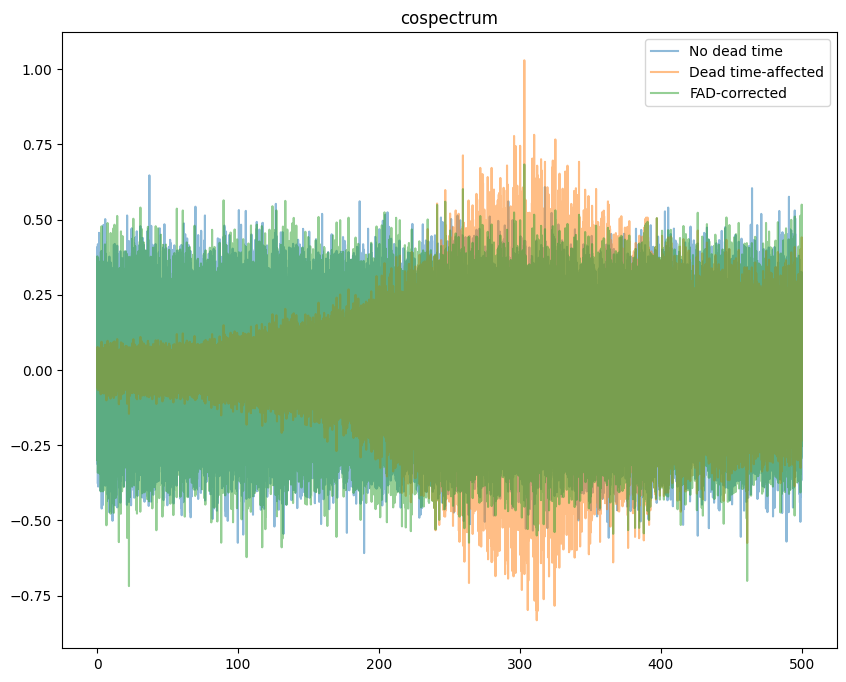

In [7]:
# Calculate light curves
lc1_dt = ev1_dt.to_lc(dt=dt)
lc2_dt = ev2_dt.to_lc(dt=dt)

results = \
    FAD(lc1_dt, lc2_dt, segment_size, dt, norm="leahy", plot=False,
                      smoothing_alg='gauss',
                      smoothing_length=segment_size*2,
                      strict=True, verbose=False,
                      tolerance=0.05)

freq_f = results['freq']
pds1_f = results['pds1']
pds2_f = results['pds2']
cs_f = results['cs']
ptot_f = results['ptot']

for spec, spec_dt, spec_f, label in zip(
        [pds1, pds1, ptot, cs],
        [pds1_dt, pds2_dt, ptot_dt, cs_dt],
        [pds1_f, pds2_f, ptot_f, cs_f],
        ['PDS from light curve 1', 'PDS from light curve 2', 'PDS from lcs 1+2', 'cospectrum']
        ):
    plt.figure(figsize=(10, 8))
    plt.title(label)
    plt.plot(spec.freq, spec.power, label='No dead time', alpha=0.5)
    plt.plot(spec_dt.freq, spec_dt.power, label='Dead time-affected', alpha=0.5)
    plt.plot(freq_f, spec_f, label='FAD-corrected', alpha=0.5)
    plt.legend()